In [1]:
!pip install sentencepiece
!pip install tf_sentencepiece

     |████████████████████████████████| 1.0MB 3.5MB/s 
     |████████████████████████████████| 2.7MB 3.5MB/s 


In [2]:
!pip install fastai==1.0.52
from fastai import *
from fastai.text import *

import re
import sentencepiece as spm

     |████████████████████████████████| 225kB 3.5MB/s 
  Found existing installation: fastai 1.0.57
    Uninstalling fastai-1.0.57:
      Successfully uninstalled fastai-1.0.57


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
wiki=path/'Thesis Data'/'wiki_data'/'Wiki'

## Training

In [0]:
vocab_size = 30000
model_prefix = 'sp_wiki'

In [6]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

True

In [0]:
itos = [] #{}
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

In [8]:
len(itos)

30000

In [9]:
itos[:5], itos[-5:]

(['<unk>', '<s>', '</s>', '▁', '।'],
 ['এইচএসপিএ', '▁ইকরিমা', '▁উস্কানি', '▁বাদানুবাদ', '/'])

In [0]:
class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)

In [0]:
#setup Vocab object for use in LM
sp_vocab = Vocab(itos)

In [0]:
mycust_tok = CustomTokenizer(SPTokenizer,model_prefix)

In [0]:
bs = 32
bptt = 70

## Our AA

#### Our AA (LM)

In [0]:
data_lm_AA = TextLMDataBunch.from_csv(aa , 'OurDataset_train.csv', bs=bs , bptt=bptt,tokenizer=mycust_tok, vocab=sp_vocab)
data_lm_AA.save('train_AA_subword_wiki_lm.pkl')

In [0]:
data_lm_AA = load_data(aa, 'train_AA_subword_wiki_lm.pkl',bs=bs)

In [0]:
data_lm_AA.show_batch()

idx,text
0,াম ▁এখন ▁ফুটবল ▁খেলে ▁ফিরে ▁আস ছি । ▁রাজাকার গুলি ▁আমাদের ▁মনে ▁রেখেছে ▁কি ▁না ▁ কে ▁জানে — ▁রাখলে ▁ক্ষতি ▁নেই ▁দেখে ▁কোন ▁সন্দেহ ▁করবে ▁না । ▁প্রথমবার ▁অা মালে ঞ্চ ▁ফে ক্স কম ▁ভয় ▁ভয় ▁ লাগ ছিল ▁এবার ে ▁সেরকম ▁ভয় ও ▁লাগল ▁না । ▁আমি ▁একটা ▁রাজাকার কে ▁জিজ্ঞেস ও ▁করলাম ▁কয় টা ▁বাজে । ▁রাজাকার টা ▁অব ি শ্য ি ▁আমার ▁প্রশ্নের ▁উত্তর ▁দিল ▁না
1,"▁মুখ ▁করে ▁বলে , ▁তা ▁হলে ▁সেই ▁কথা ই । ▁আমাকে ও ▁বলেছে , ▁আপনাকে ও ▁বলেছে । ▁ দীপ নাথ ▁মাথা ▁নে ড়ে ▁বলে , ▁হয়তো ▁সেই ▁উদ্দেশ্যে ই ▁আজ ▁উনি ▁আমাকে ▁এখানে ▁নিয়ে ▁এসেছেন । ▁মণি দীপ ার ▁মা জা ▁রং ও ▁ রাঙা ▁হল ▁এ ▁কথায় । ▁সে ▁বলল , ▁ ছি ঃ ▁ ছি ঃ । ▁ও ▁কোথায় ▁গেল ? ▁বাথ রুম ে । – দীপ"
2,"▁এক ▁ ভ ৃত ্য ▁এলো ▁তার ▁হাতে ▁জল ▁ঢেলে ▁দিতে । ▁হাত ▁মুখ ▁প্র ক্ষা লন ▁করে ▁নবীন কুমার ▁বল লো , ▁গোপাল কে ▁একবার ▁দে কেই ▁আমি ▁চলে ▁যা বো । ▁বি ম্ব বতী ▁বললেন , ▁থাক ▁না , ▁এ খুন । ▁আর ▁যা স নি ! ▁– কেন ? ▁— এ খুন ▁ও র ▁কাচ ে ▁যেতে ▁নেই ! ▁ঠিক ▁তখনই ▁এ ▁বাড়ির ▁এক ▁আশ্রিত ▁যুবক ▁এসে"
3,ভ দ্দ র লোক ের ▁ছেলে ▁তো দের ▁ কে ▁বলল ? ▁আমরা ▁বি ল্লি ▁কাট ▁দিয়া ▁মানুষ । ▁আমাদের কে ▁বি ল্লি ▁কেটে ▁দিয়েছে । ▁বজলু র ▁কথা ▁শেষ ▁হবার ▁আগেই ▁জহির ▁এবং ▁মোবারক ▁হাস তে ▁শুরু ▁করল । ▁বোতল ▁খোলার ▁আগেই ▁তিনজন ▁চলে ▁যাচ্ছে ▁ভাবে র ▁জগতে । ▁আজকে র ▁ভাব ▁হবে ▁জটিল ▁ভাব । ▁রাত টা ▁বড় ই ▁আনন্দ ে ▁কাট বে । ▁ বুড়ো ▁ বুড়ি
4,"আমি ▁তো ▁চল লাম ! ▁তো রা ▁কি ▁থাকি বি , ▁না ▁আমার ▁সঙ্গে ▁যা বি ? ▁থাক ব ▁কী ! ▁বললেন ▁লালমোহন বাবু । ▁এর ▁পরে ▁কি ▁আর ▁থাকা ▁যায় ? ▁চল ুন ▁বেরিয়ে ▁পড় ি । ▁আমরা ▁তিনজন ▁যখন ▁ নয়ন পুর ▁ভিলা ▁ পী ছ লাম , ▁তখন ▁সোয়া ▁ছ টা । ▁ চারি দিক ▁অন্ধকার ▁হয়ে ▁গেছে , ▁আকাশে ▁মেঘ , ▁ টিপ ▁ টিপ ▁করে"


In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(wiki/'models'/'wiki_subword_lm_30');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


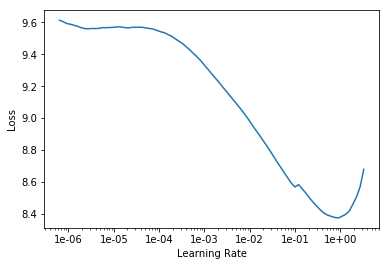

In [0]:
learn.lr_find();
learn.recorder.plot();

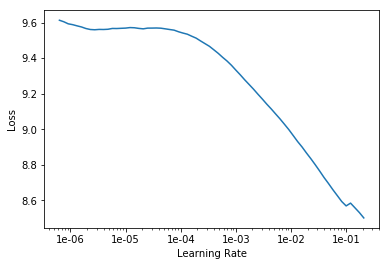

In [0]:
learn.recorder.plot(skip_end=20);

In [0]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_subword_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,5.269609,5.108425,0.201604,20:26
1,4.996903,4.833389,0.225040,20:26


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_subword_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,4.906767,4.831881,0.229587,20:54
1,4.615565,4.535242,0.258548,20:53


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_subword_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,4.754187,4.706779,0.243564,22:37
1,4.462883,4.365650,0.278231,22:36


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_subword_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.731855,4.620867,0.250138,23:29
1,4.353949,4.292725,0.284804,23:25


In [0]:
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_subword_lm_body_4')

epoch,train_loss,valid_loss,accuracy,time
0,4.605798,4.532569,0.258661,23:27
1,4.262324,4.232949,0.290902,23:24


In [0]:
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_subword_lm_body_5')

epoch,train_loss,valid_loss,accuracy,time
0,4.550877,4.487486,0.263349,23:28
1,4.259408,4.201203,0.293905,23:27


In [0]:
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_subword_lm_body_6')

epoch,train_loss,valid_loss,accuracy,time
0,4.520964,4.460174,0.265634,23:28
1,4.249434,4.180352,0.296148,23:28


In [0]:
learn.fit_one_cycle(2, 1e-3) #because the loss is oscillating
learn.save('AA_wiki_subword_lm_body_7')

epoch,train_loss,valid_loss,accuracy,time
0,4.135206,4.145817,0.299253,23:27
1,4.042067,4.120842,0.302177,23:25


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_subword_lm_body_8')

epoch,train_loss,valid_loss,accuracy,time
0,4.110393,4.118984,0.302080,23:26
1,3.968954,4.097110,0.304925,23:23


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_subword_lm_body_9')

epoch,train_loss,valid_loss,accuracy,time
0,4.040770,4.101536,0.303871,23:28
1,4.052423,4.080987,0.306699,23:27


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_subword_lm_body_10')

epoch,train_loss,valid_loss,accuracy,time
0,4.028419,4.089589,0.305448,23:26
1,3.991813,4.068210,0.308125,23:27


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_subword_lm_body_11')

epoch,train_loss,valid_loss,accuracy,time
0,4.048450,4.081283,0.306322,23:26
1,3.966646,4.057884,0.309220,23:27


In [0]:
learn.load('AA_wiki_subword_lm_body_11')
learn.save_encoder('AA_subword_lm_enc')

#### Classifier (our AA)

In [0]:
data_clas = load_data(aa, 'AA_subword_wiki_clas.pkl',bs=bs)
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)
learn_cls.load_encoder('AA_wiki_subword_lm_enc')

In [19]:
data_clas.show_batch()

text,target
"▁xx bo s ▁নির্ বি ঘ্ন ে ▁নিষ্ ক্রান্ত ▁হই লেন । ▁বিমলা ▁ফটক ▁হইতে ▁কি য় দ্ দূর ▁গমন ▁করিয়া ▁দেখি লেন ▁যে , ▁একজন ▁পুরুষ ▁এক ▁বৃক্ষ তলে ▁দাঁড় াইয়া ▁আছেন । ▁দৃষ্টি মাত্র ▁বিমলা ▁ তাঁ হা কে ▁অভি রাম ▁স্বামী ▁বল িয়া ▁চিনি তে ▁পারি লেন । ▁বিমলা ▁তাঁহার ▁নিকট ▁যাই বা মাত্র ▁অভি রাম ▁স্বামী ▁ ক হি লেন , ▁“ আমি ▁বড় ই ▁উদ্বিগ্ন",bongkim
"▁xx bo s ▁বিশাল া ক্ষি ▁ভক্ত ানা মার্ ত্তি নাশ িনি ▁ । ▁ ন মা মি ▁শির সা ▁দেবী ং ▁বন্ধ নো হ স্তু ▁বি ম োচিত ঃ ▁ । । 14 ▁xx rep ▁6 ▁— ▁– ▁14 ▁আর্য ্যা স্তো ত্র ▁দেখ ▁দ্বাদশ ▁সংখ্যা - একটি ▁গীত ▁“ শো ন্ ▁ প্রসন্ন , ▁তো কে ▁একটি ▁গীত ▁শু নাই ব । ” ▁ প্রসন্ন ▁গোয়াল িনী ▁বলি",bongkim
"▁xx bo s ▁সম্রাটের া ▁যে রূপ ▁পারি ষ দ মণ্ডলী ▁মধ্যে ▁আমোদ - পরায়ণ ▁থাকি তেন , ▁কত লু ▁খাঁর ▁সে রূপ ▁ছিল ▁না । ▁কত লু ▁খাঁর ▁ চিত্ত ▁একান্ত ▁আত্ম সুখ রত , ▁ইন্দ্রিয় তৃপ্তি র ▁অভি লা ষী । ▁অ দ্য ▁রাত্রে ▁তিনি ▁একাকী ▁নিজ ▁ বিলাস - গৃহ নি বাসিনী গণ ে ▁পরিবেষ্টিত ▁হইয়া ▁তাহা দি গের ▁নৃত্য গীত ▁কৌতুক ে ▁ মত্ত ▁ছিলেন ।",bongkim
"▁xx bo s ▁তান - লয় ের ▁পরিবর্তন ▁দেখা ইল । ▁তারপর ▁সহ সা ▁বাঁশি ▁ স্ত ব্ধ ▁হইল । ▁“ বাঁশ ি ▁কি ▁বলি ল ? ” ▁সোম দ ত্তা ▁যেন ▁ ত ন্দ্রা র ▁ঘোর ▁হইতে ▁জা গিয়া ▁উ ঠি ল । ▁অতি ▁দীর্ঘ ▁এক ▁নি শ্বাস ▁ত্যাগ ▁করিয়া ▁ ক হিল , ▁“ তুমি ▁যা হা ▁চাও ▁পাই বে । ▁ চন্দ ্ৰ বর্ মা ▁তো মা",shordindu
"▁xx bo s ▁দেখি তে ▁আ সিল । ▁সুন্দরী ▁শৈব লি নীর ▁মৃত্যু সম্ বাদ ▁শু নিয়া ▁নিতান্ত ▁দুঃখ িতা ▁হইল , ▁কিন্তু ▁বলি ল , ▁“ যা হা ▁হই বার ▁তাহা ▁হইয়া ছে । ▁কিন্তু ▁শৈব লিন ী ▁এখন ▁সুখী ▁হইল । ▁তাহার ▁বাঁচা ▁অপেক্ষা ▁মরা ই ▁যে ▁সুখ ের , ▁তা ▁আর ▁কোন্ ▁মুখে ▁না ▁বলি ব ? ” ▁প্রতাপ , ▁রূপ সী ▁ও ▁সুন্দরী র ▁সাক্ষাতের ▁পর",bongkim


In [20]:
len(data_clas.y.classes)

16

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


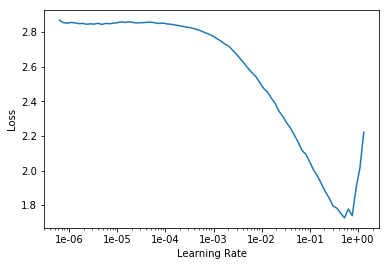

In [18]:
learn_cls.freeze()
learn_cls.lr_find()
learn_cls.recorder.plot()

In [22]:
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('wiki_subword_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.091270,0.029695,0.990609,13:55
1,0.045557,0.018312,0.996522,13:55


In [23]:
learn_cls.load('wiki_subword_cls_1')
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('wiki_subword_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.060987,0.019579,0.995130,15:50
1,0.019999,0.014673,0.996522,15:52


In [24]:
learn_cls.load('wiki_subword_cls_2')
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('wiki_subword_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.020911,0.015503,0.996870,24:01
1,0.007645,0.013167,0.997565,23:32


In [25]:
learn_cls.load('wiki_subword_cls_3')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('wiki_subword_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.007565,0.013097,0.997565,30:09
1,0.004535,0.014359,0.997217,30:25


In [26]:
learn_cls.load('wiki_subword_cls_4')
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('wiki_subword_cls_5')

epoch,train_loss,valid_loss,accuracy,time
0,0.007769,0.012623,0.997565,30:16
1,0.002741,0.012767,0.997913,30:41


In [27]:
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('wiki_subword_cls_6') ##loss increased, so cant use

epoch,train_loss,valid_loss,accuracy,time
0,0.002520,0.014938,0.997217,30:31
1,0.003455,0.013572,0.998261,30:29


In [0]:
learn_cls.load('wiki_subword_cls_5');

In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  return final_preds, targets

In [33]:
pred,targ = testing(aa/'OurDataset_test.csv')

3592
Accuracy: 
0.9972160356347439
[('robindronath', 'bongkim'), ('shordindu', 'shirshendu'), ('shordindu', 'bongkim'), ('shottojit_roy', 'shunil_gongopaddhay'), ('manik_bandhopaddhay', 'shirshendu'), ('humayun_ahmed', 'MZI'), ('manik_bandhopaddhay', 'shunil_gongopaddhay'), ('shordindu', 'bongkim'), ('humayun_ahmed', 'MZI'), ('shirshendu', 'humayun_ahmed')]


In [34]:
from sklearn.metrics import f1_score
out  = f1_score(targ, pred, average='weighted')
out

0.9972169971121483

In [35]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(targ, pred)
print(cm)

[[220   0   0   0 ...   0   0   0   0]
 [  0 112   0   0 ...   0   0   0   0]
 [  2   0 904   0 ...   0   0   0   0]
 [  0   0   0  91 ...   1   0   0   0]
 ...
 [  0   0   0   0 ... 393   0   0   0]
 [  0   0   0   0 ...   0 155   0   0]
 [  0   0   0   0 ...   0   0 186   0]
 [  0   0   0   0 ...   0   0   0  37]]


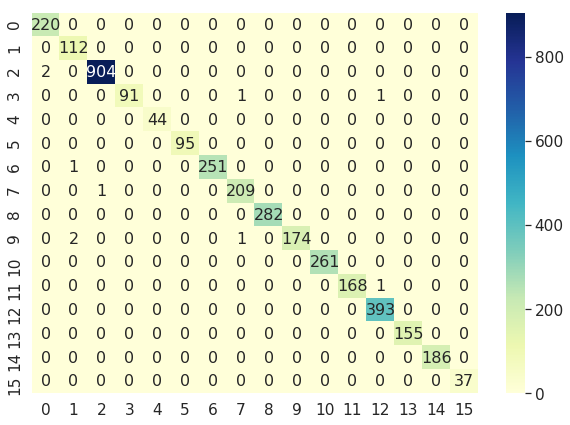

In [36]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(16),range(16))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap="YlGnBu")# font size

import matplotlib.pyplot as plt
plt.savefig('wiki_subword_AA.eps')

In [0]:
from google.colab import files
files.download('wiki_subword_AA.eps')